In [22]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

# Links
links = [
    "https://da.wikipedia.org/wiki/Folketingsmedlemmer_valgt_i_2022",
    "https://da.wikipedia.org/wiki/Folketingsmedlemmer_valgt_i_2019",
    "https://da.wikipedia.org/wiki/Folketingsmedlemmer_valgt_i_2015",
    "https://da.wikipedia.org/wiki/Folketingsmedlemmer_valgt_i_2011",
    "https://da.wikipedia.org/wiki/Folketingsmedlemmer_valgt_i_2007",
    "https://da.wikipedia.org/wiki/Folketingsmedlemmer_valgt_i_2005",
    "https://da.wikipedia.org/wiki/Folketingsmedlemmer_valgt_i_2001",
    "https://da.wikipedia.org/wiki/Folketingsmedlemmer_valgt_i_1998",
    "https://da.wikipedia.org/wiki/Folketingsmedlemmer_valgt_i_1994",
    "https://da.wikipedia.org/wiki/Folketingsmedlemmer_valgt_i_1990",
    "https://da.wikipedia.org/wiki/Folketingsmedlemmer_valgt_i_1988",
    "https://da.wikipedia.org/wiki/Folketingsmedlemmer_valgt_i_1987",
    "https://da.wikipedia.org/wiki/Folketingsmedlemmer_valgt_i_1984",
    "https://da.wikipedia.org/wiki/Folketingsmedlemmer_valgt_i_1981",
    "https://da.wikipedia.org/wiki/Folketingsmedlemmer_valgt_i_1979",
    "https://da.wikipedia.org/wiki/Folketingsmedlemmer_valgt_i_1975",
    "https://da.wikipedia.org/wiki/Folketingsmedlemmer_valgt_i_1971",
    "https://da.wikipedia.org/wiki/Folketingsmedlemmer_valgt_i_1968",
    "https://da.wikipedia.org/wiki/Folketingsmedlemmer_valgt_i_1964",
    "https://da.wikipedia.org/wiki/Folketingsmedlemmer_valgt_i_1960"
]

# Tabelnavne
table_names = [
    "De valgte medlemmer",
    "Valgte folketingsmedlemmer",
    "Valgte medlemmer ved valget 13.11.2007",
    "Liste over medlemmerne",
    "Valgte folketingsmedlemmer ved valget 18.6.2015",
    "Valgte folketingsmedlemmer ved valget 5. juni 2019",
    "Valgte 1. november 2022"
]


all_data = []

for link in links:
    response = requests.get(link)
    soup = BeautifulSoup(response.content, 'html.parser')
    
    # Find tabel baseret på tabelnavne
    table = None
    for table_name in table_names:
        target_header = soup.find('span', {'id': table_name.replace(" ", "_")})
        if target_header:
            table = target_header.find_next('table')
            break
    
    # Hvis en tabel er fundet, fortsæt med at scrappe data
    if table:
        for row in table.findAll('tr')[1:]:
            cells = row.findAll('td')
            if cells and len(cells) > 1:
                name = cells[0].get_text(strip=True)
                party = cells[1].get_text(strip=True)
                all_data.append({'Name': name, 'Party': party, 'Year': link.split('_')[-1]})

# Omdan til pandas DataFrame
df = pd.DataFrame(all_data)

# Viser de første rækker af DataFrame for kontrol
print(df.head())


                         Name              Party  Year
0                   Ida Auken  Socialdemokratiet  2022
1           Peter Hummelgaard  Socialdemokratiet  2022
2             Mette Reissmann  Socialdemokratiet  2022
3  Pernille Rosenkrantz-Theil  Socialdemokratiet  2022
4                 Jeppe Bruus  Socialdemokratiet  2022


In [23]:
period_counts = df.groupby('Name').size()

years_served = df.groupby('Name')['Year'].apply(list)

aggregated_df = pd.DataFrame({
    'Period_Count': period_counts,
    'Years_Served': years_served
}).reset_index()

def detect_gaps(year_list):
    if len(year_list) <= 1:
        return False
    
    # Konverter til heltal
    sorted_years = sorted([int(year) for year in year_list])
    
    for i in range(len(sorted_years)-1):
        if sorted_years[i+1] - sorted_years[i] > 4:
            return True
    return False

aggregated_df['Had_Pause'] = aggregated_df['Years_Served'].apply(detect_gaps)

In [24]:
aggregated_df = aggregated_df.drop(0)

aggregated_df.to_csv("politicians_data.csv", index=False)

aggregated_df.head()



,Name,Period_Count,Years_Served,Had_Pause
1,A. Aage Andersen,1,[1979],False
2,A. Stæhr Johansen,2,"[1971, 1964]",True
3,A.C. Normann,3,"[1971, 1964, 1960]",True
4,Aage Brusgaard,3,"[1994, 1990, 1988]",False
5,Aage Fogh,1,[1960],False


In [25]:
years_served = df.groupby('Name')['Year'].apply(list)


In [26]:
start_year = df.groupby('Name')['Year'].min()
end_year = df.groupby('Name')['Year'].max()


In [27]:
aggregated_df = pd.DataFrame({
    'Period_Count': period_counts,
    'Years_Served': years_served
}).reset_index()


In [28]:
aggregated_df = pd.DataFrame({
    'Period_Count': period_counts,
    'Years_Served': years_served,
    'Start_Year': start_year,
    'End_Year': end_year
}).reset_index()


In [29]:
#Fjerner politikere med start år i 1960.
aggregated_df = aggregated_df[aggregated_df['Start_Year'] != '1960']


In [30]:
aggregated_df = aggregated_df.drop(0)

aggregated_df.to_csv("politicians_data.csv", index=False)

aggregated_df.head()



,Name,Period_Count,Years_Served,Start_Year,End_Year
1,A. Aage Andersen,1,[1979],1979,1979
2,A. Stæhr Johansen,2,"[1971, 1964]",1964,1971
4,Aage Brusgaard,3,"[1994, 1990, 1988]",1988,1994
6,Aage Frandsen,6,"[2001, 1998, 1994, 1988, 1987, 1971]",1971,2001
7,Aage Hastrup,2,"[1971, 1964]",1964,1971


# Survival model

In [31]:
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt


In [32]:
def detect_gaps(year_list):
    if len(year_list) <= 1:
        return False
    sorted_years = sorted([int(year) for year in year_list])
    for i in range(len(sorted_years)-1):
        if sorted_years[i+1] - sorted_years[i] > 4:
            return True
    return False

aggregated_df['Had_Pause'] = aggregated_df['Years_Served'].apply(detect_gaps)

# Hvis vi ikke allerede har 'Duration' kolonnen, tilføjer vi den:
aggregated_df['Duration'] = aggregated_df['End_Year'].astype(int) - aggregated_df['Start_Year'].astype(int)


In [33]:
# Hvis en politiker havde en pause, betragter vi det som en "død" i denne analyse, dvs. de stoppede med politik.
T = aggregated_df['Duration']
E = aggregated_df['Had_Pause'].astype(int)


In [34]:
kmf = KaplanMeierFitter()
kmf.fit(T, event_observed=E)


<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 1085 total observations, 930 right-censored observations>

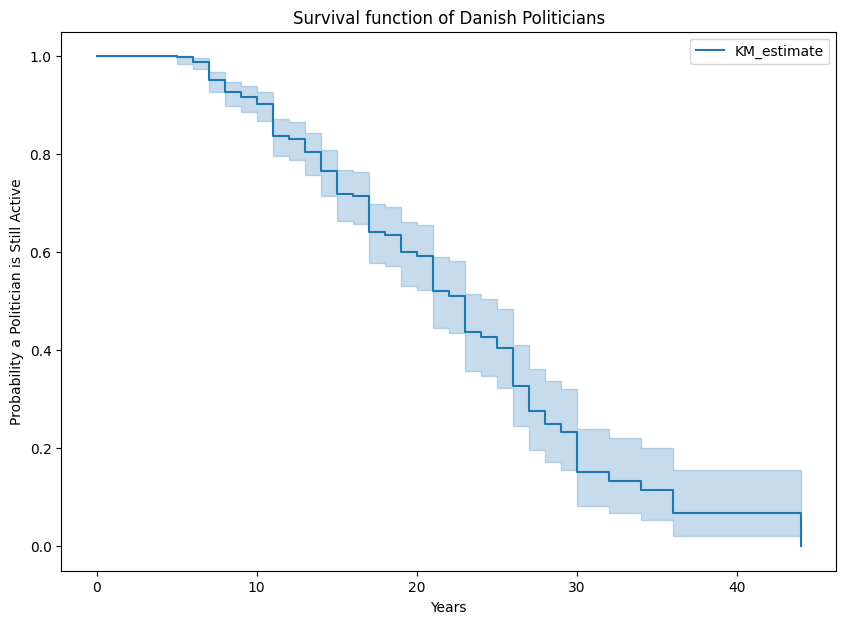

In [35]:
plt.figure(figsize=(10,7))
kmf.plot()
plt.title("Survival function of Danish Politicians")
plt.ylabel("Probability a Politician is Still Active")
plt.xlabel("Years")
plt.show()


# Lidt ekstra:

In [36]:
unique_politicians_count = aggregated_df['Name'].nunique()
print(f"Antallet af unikke politikere, der har siddet i Folketinget i perioden 1960-2022: {unique_politicians_count}")

Antallet af unikke politikere, der har siddet i Folketinget i perioden 1960-2022: 1085


# Her har jeg hentet ANTAL HITS pr år

In [ ]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options  
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup
import pandas as pd
import re
import time

chrome_options = Options()
chrome_options.add_argument('--headless')

def get_hits_for_politician(name):
    driver = webdriver.Chrome(options=chrome_options)  
    url = f"https://www.information.dk/search/site/{name.replace(' ', '%20')}"
    driver.get(url)

    try:
        element = WebDriverWait(driver, 10).until(
            EC.presence_of_element_located((By.ID, "acceptButton"))
        )
        element.click()
    except:
        print(f"Kunne ikke finde eller klikke på acceptButton for {name}.")

    page_source = driver.page_source
    soup = BeautifulSoup(page_source, 'html.parser')
    
    # Initialize all years with 0
    data = {str(year): 0 for year in range(1960, 2024)}  

    years_section = soup.find('div', class_='pane-content')
    if years_section:
        year_links = years_section.find_all('a', class_='facetapi-inactive')
        for link in year_links:
            year_text = link.get_text()
            match = re.search(r'(\d{4}) \((\d+)\)', year_text)
            if match:
                year, count = match.groups()
                data[year] = int(count)

    driver.quit()
    data["Name"] = name
    return data

# Initialize the CSV with headers if it doesn't exist
try:
    pd.read_csv('politicians_data1.csv')
except FileNotFoundError:
    headers = ["Name"] + [str(year) for year in range(1960, 2024)]
    initial_df = pd.DataFrame(columns=headers)
    initial_df.to_csv('politicians_data1.csv', index=False)

# Check if there's any existing data
try:
    existing_data = pd.read_csv('politicians_data1.csv')
    scraped_politicians = set(existing_data["Name"].tolist())
except FileNotFoundError:
    scraped_politicians = set()

politicians = aggregated_df["Name"]

for name in politicians:
    if name not in scraped_politicians:
        row = get_hits_for_politician(name)
        # Gem i CSV efter hver politiker (append mode)
        temp_df = pd.DataFrame([row])
        temp_df.to_csv('politicians_data1.csv', mode='a', header=False, index=False)
        # Pause for at undgå at overbelaste serveren
        time.sleep(10)  # Pause i 10 sekunder

df = pd.read_csv('politicians_data1.csv')
df.set_index("Name", inplace=True)

df


Denne kode tog cirka 5 timer at køre 

In [ ]:
df.rename(columns={'2023': 'Name1'}, inplace=True)


In [ ]:
for year in range(2022, 1959, -1):
    df.rename(columns={str(year): str(year+1)}, inplace=True)

df.rename(columns={'Name': '1960'}, inplace=True)


In [ ]:
df.rename(columns={'Name1': 'Name'}, inplace=True)

df 

# Nu bruger jeg denne data og merger med min anden data, så jeg kan markere, hvornår de gik ud af politik

In [ ]:
import pandas as pd

# Antager at aggregated_df og df er defineret som tidligere

# Konverter "Name"-kolonnen i begge dataframes til strengtype
df['Name'] = df['Name'].astype(str)
aggregated_df['Name'] = aggregated_df['Name'].astype(str)

# Vi joiner aggregated_df og df på "Name"
combined_df = df.join(aggregated_df.set_index('Name'), on='Name')

# fjern NaN værdier fra alle kolonner, som har numeriske værdier
combined_df.fillna(0, inplace=True)

# Konverter kun de nødvendige kolonner (årskolonnerne) til int
for col in combined_df.columns:
    if col.isnumeric():  # Tjekker om kolonnenavnet er et årstal
        combined_df[col] = combined_df[col].astype(int)

def highlight_year(row):
    """ Denne funktion markerer året, hvor politikeren forlod politik, med rødt """
    color = {}
    # Hvis End_Year er mindre end 2022, så tages det år, ellers tages intet
    end_year = row['End_Year'] if row['End_Year'] < 2022 else None
    for column in combined_df.columns:
        if str(end_year) == column:  # Check om kolonnen matcher det år, politikeren forlod politik
            color[column] = 'background-color: red'
        else:
            color[column] = ''
    return pd.Series(color)

# Vis combined_df med style-applikationen
styled_df = combined_df.style.apply(highlight_year, axis=1)
styled_df


In [ ]:
# Kopier den originale dataframe
new_df = combined_df.copy()

# Filter rækker, hvor politikeren forlod politik og der ikke var nogen omtale det år eller tidligere år
to_drop = []

for index, row in new_df.iterrows():
    end_year = row['End_Year']
    # Hvis End_Year er mindre end 2022
    if end_year < 2022:
        # Hvis summen af medieomtale for det år og alle tidligere år er 0
        if sum(row[str(year)] for year in range(1960, int(end_year)+1)) == 0:
            to_drop.append(index)

# Drop de identificerede rækker
new_df.drop(to_drop, inplace=True)

new_df.reset_index(drop=True, inplace=True)


In [ ]:
# Find alle kolonner med en sum på 0
cols_to_drop = [col for col in new_df.columns if new_df[col].sum() == 0 and col.isnumeric()]

# Drop de identificerede kolonner
new_df.drop(columns=cols_to_drop, inplace=True)

#Efter at have udført denne kode, vil new_df ikke have nogen kolonner (år), hvor summen af hits for alle politikere er 0.

new_df 

In [ ]:
# Gemmer dataframes som CSV-filer
new_df.to_csv('filtered_data.csv', index=False)
df.to_csv('original_data.csv', index=False)


# Artikler hentes her! 

In [ ]:
from selenium import webdriver
from bs4 import BeautifulSoup

def scrape_single_page(url):
    driver = webdriver.Chrome(options=chrome_options)
    driver.get(url)
    html = driver.page_source
    soup = BeautifulSoup(html, 'html.parser')
    

    all_divs = soup.find_all('div')
    

    article_divs = [div for div in all_divs if "node-article" in str(div)]
    

    data_list = []
    for article in article_divs:
        data = {}
        title_element = article.find('h3')
        if title_element:
            data["Titel"] = title_element.text.strip()
        if data:  
            data_list.append(data)

    driver.close()
    return data_list

# Test scraping
url = "https://www.information.dk/search/site/Aki-Matilda%2520H%25C3%25B8egh-Dam"
data_list = scrape_single_page(url)
#print(data_list)
unique_data_list = [dict(t) for t in {tuple(d.items()) for d in data_list}]
print(unique_data_list)



In [ ]:
from selenium import webdriver
from bs4 import BeautifulSoup
from time import sleep
import csv

chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument("--headless")

def scrape_single_page(url, politician_name):
    driver = webdriver.Chrome(options=chrome_options)
    driver.get(url)
    sleep(2)  # Pause, og vent på load
    html = driver.page_source
    soup = BeautifulSoup(html, 'html.parser')
    all_divs = soup.find_all('div', class_='node-article')
    data_list = []

    for article in all_divs:
        data = {}
        title_element = article.find('h3')
        if title_element:
            data["Titel"] = title_element.text.strip()
        
        date_element = article.find('li', class_='date')
        if date_element:
            data["Dato"] = date_element.text.strip()
        
        subtitle_element = article.find('div', class_='field-name-field-web-underrubrik')
        if subtitle_element:
            data["Underrubrik"] = subtitle_element.text.strip()
        
        data["Politiker"] = politician_name  # Navn
        
        if data:
            data_list.append(data)

    driver.close()
    return data_list

def get_article_data_for_politician(name):
    base_url = f"https://www.information.dk/search/site/{name.replace(' ', '%20')}"
    page_number = 0
    all_data = []

    while True:
        current_url = f"{base_url}?page={page_number}" if page_number > 0 else base_url
        current_data = scrape_single_page(current_url, name)  # Navn
        if not current_data:  # Hvis vi ikke får ny data, har vi nået enden
            break
        all_data.extend(current_data)
        page_number += 1

    return all_data

def save_to_csv(data_list, filename):
    keys = ["Politiker", "Titel", "Dato", "Underrubrik"]
    with open(filename, 'w', newline='', encoding='utf-8') as output_file:
        dict_writer = csv.DictWriter(output_file, fieldnames=keys)
        dict_writer.writeheader()
        dict_writer.writerows(data_list)

if __name__ == "__main__":
    politician_name = "Aki-Matilda Høegh-Dam"
    data = get_article_data_for_politician(politician_name)
    save_to_csv(data, "articles.csv")
    
    # Konverter data-listen til en pandas DataFrame og vis den
    df = pd.DataFrame(data)


In [ ]:
df

In [ ]:
import pandas as pd
from afinn import Afinn

# 1. Læs datasættet og kombiner 'Titel' og 'Underrubrik'
data = pd.read_csv('articles.csv')
data['Combined_Text'] = data['Titel'] + ". " + data['Underrubrik']

# 2. Rens teksten
def clean_text(document):
    document = document.lower()  # Konverter til små bogstaver
    document = re.sub(r'<[^>]*>', ' ', document)  # Fjern HTML
    document = re.sub(r'[^\w\s]', '', document)  # Fjern ikke-alfanumeriske tegn
    return document

data['Cleaned_Text'] = data['Combined_Text'].apply(clean_text)

# 3. Brug AFINN til sentiment-analyse
afinn = Afinn(language='da')  # 'da' står for dansk
data['AFINN_Score'] = data['Cleaned_Text'].apply(afinn.score)

# Konverter AFINN scores til kategoriske labels
def score_to_label(score):
    if score > 0:
        return 1   # positive
    elif score < 0:
        if score < -2:
            return -2  # extra negative
        return -1  # negative
    else:
        return 0   # neutral

data['Label'] = data['AFINN_Score'].apply(score_to_label)

# Gem dataen
data.to_csv('updated_data_with_labels.csv', index=False)


In [ ]:
import pandas as pd

# CSV-filen
df = pd.read_csv('updated_data_with_labels.csv')

#  DataFrame
df.head()


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from joblib import dump, load

# 1. Opdeling af Data
X = data['Cleaned_Text']  # Opdateret kolonnenavnet her
y = data['Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. Vektorisering af Tekst
vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# 3. Træning af Modellen
model = LogisticRegression(random_state=0, max_iter=1000)  # Øget max_iter for at undgå konvergensproblemer
model.fit(X_train_vec, y_train)

# 4. Evaluering
y_pred = model.predict(X_test_vec)
print(classification_report(y_test, y_pred))

# 5. Gem modellen og vectorizer for senere brug
dump(model, 'logistic_regression_model.joblib')
dump(vectorizer, 'tfidf_vectorizer.joblib')

# Når vi vil indlæse modellen og vectorizer senere:
# model = load('logistic_regression_model.joblib')
# vectorizer = load('tfidf_vectorizer.joblib')


In [ ]:
print(classification_report(y_test, y_pred, zero_division=1))
